In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import networkx as nx
import seaborn as sns
from itertools import product
from collections import Counter, defaultdict
import warnings
warnings.filterwarnings('ignore')

# Set up plotting
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)

---

### Helper functions to create a Boolean network

In [2]:
# 🟢 Helper class to build and simulate boolean network
class BooleanNetwork:
    def __init__(self, node_names):
        self.nodes = {name: 0 for name in node_names}
        self.rules = {}
        self.history = []
        self.graph = nx.DiGraph()  # NetworkX graph for visualization

        # Add nodes to NetworkX graph
        self.graph.add_nodes_from(node_names)

    def add_rule(self, target_node, rule_function, rule_description=""):
        """
        Add Boolean rule for a node

        Args:
            target_node: Node to update
            rule_function: Function that takes current state dict and returns True/False
            rule_description: Human-readable description
        """
        self.rules[target_node] = {
            'function': rule_function,
            'description': rule_description
        }

    def set_state(self, **kwargs):
        """Set states of specific nodes"""
        for node, value in kwargs.items():
            if node in self.nodes:
                self.nodes[node] = int(bool(value))

    def get_state_vector(self):
        """Get current state as list in sorted order"""
        return [self.nodes[node] for node in sorted(self.nodes.keys())]

    def update_synchronous(self):
        """Update all nodes simultaneously"""
        new_state = {}
        for node in self.nodes:
            if node in self.rules:
                new_state[node] = int(self.rules[node]['function'](self.nodes))
            else:
                new_state[node] = self.nodes[node]  # No rule = no change

        self.nodes = new_state
        self.history.append(self.get_state_vector())

    def simulate(self, steps=10, record_history=True):
        """Run simulation"""
        if record_history:
            self.history = [self.get_state_vector()]

        for step in range(steps):
            self.update_synchronous()

            # Check for steady state
            if len(self.history) >= 2 and self.history[-1] == self.history[-2]:
                # print(f"   Reached steady state after {step+1} steps")
                break

        return np.array(self.history)



---



# Part 1: Normal cell regulatory network from Practical

## **Normal cell regulatory network**

🧬 Biological context

Cells make binary decisions:
* GROW: Divide and multiply (good for healing, bad if uncontrolled)
* DIE: Self-destruct (protective mechanism, prevents cancer)
* REST: Stay inactive (safe default state)

Key molecular switches (think: binary variables):
* DNA_damage: External damage signal (input variable)
* p53: "Tumor suppressor" - master safety switch that detects problems
* MYC: "Oncogene" - growth promoter that drives cell division
* CDK2: Cell division machinery that executes growth
* MDM2: "p53 inhibitor" - blocks p53 function (cancer exploit!)
* p21: "Cell cycle brake" - stops division when problems detected
* Growth/Death: Final binary decisions (outputs)

In [3]:
# 🟢 Create the regulatory network
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)

# Define Boolean rules (based on real biology, simplified)
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
network.add_rule('p53', lambda s: s['DNA_damage'] and not s['MDM2'], "p53 = DNA_damage AND (NOT MDM2)")
network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")

print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)


In [4]:
scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

results = {}

# Run healthy cell scenario
s = "Healthy Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run stressed cell scenario
s = "Stressed Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run oncogene hijacked cell scenario
s = "Oncogene Hijacked Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Stressed Cell: Final state: Growth=0, Death=1, p53=1
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


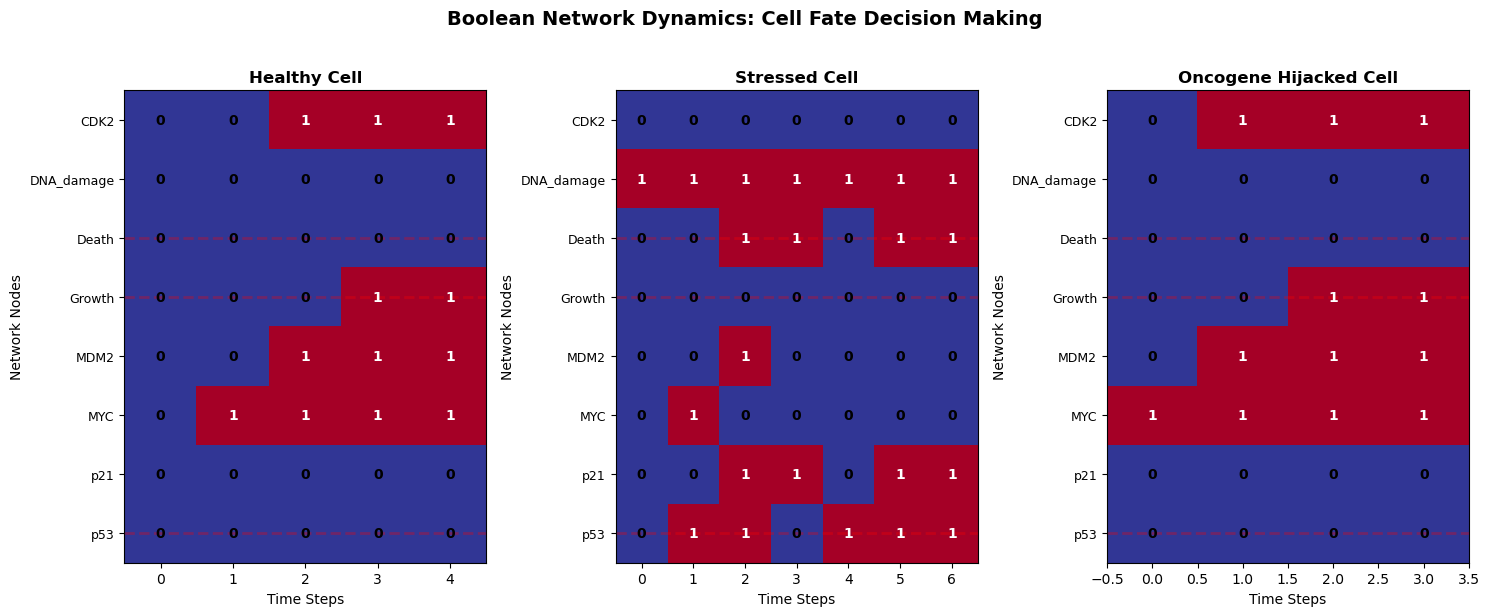

In [5]:
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))

if n_scenarios ==1:
    axes = [axes]

for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]

    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation

    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')

    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:  # Changed variable name to avoid conflict
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()


## **Attractor analysis**

In [6]:
# Let's find the attractor states
attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)
print(f"Testing all {2**n_nodes} possible initial states...")
# Generate all possible initial states
all_states = list(product([0, 1], repeat=n_nodes))
for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)
  trajectory = network.simulate(steps=max_steps)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

Testing all 256 possible initial states...



FOUND 3 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy Proliferation

Attractor 2: [0, 1, 1, 0, 0, 0, 1, 1]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → DNA Damage-Induced Apoptosis

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth despite DNA Damage (Oncogenic)


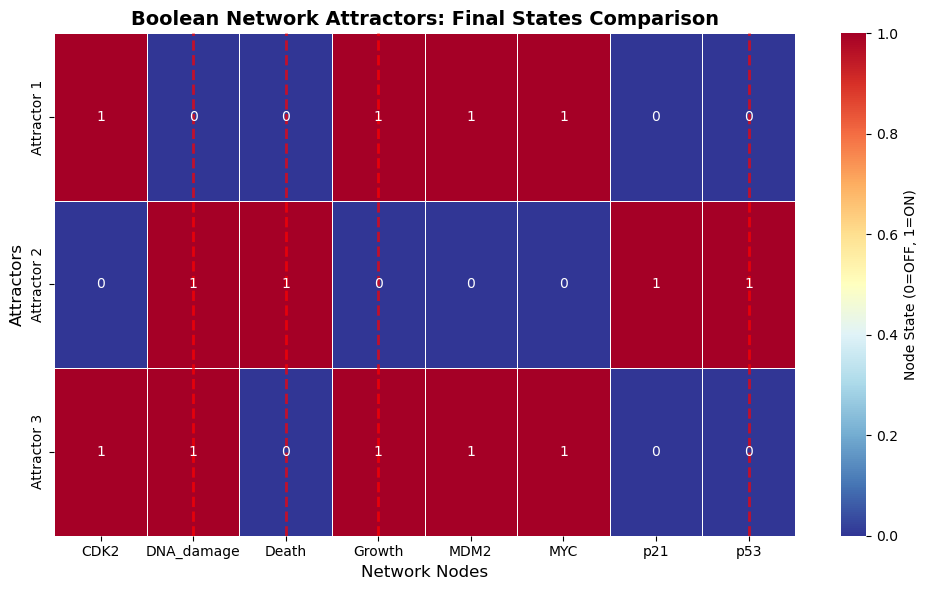

In [7]:
# 🟡 Let's find the attractor states

print(f"\nFOUND {len(attractors)} ATTRACTORS:")

for i, attractor in enumerate(attractors):
        print(f"\nAttractor {i+1}: {list(attractor)}")

        # Create state dictionary for easy access
        state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

        # Analyze the biological meaning
        growth_active = state_dict['Growth'] == 1
        death_active = state_dict['Death'] == 1
        p53_active = state_dict['p53'] == 1
        dna_damage_active = state_dict['DNA_damage'] == 1


        print(f"   Growth: {'ON' if growth_active else 'OFF'}")
        print(f"   Death: {'ON' if death_active else 'OFF'}")
        print(f"   p53: {'ON' if p53_active else 'OFF'}")
        print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

        if growth_active and not death_active and not dna_damage_active: interpretation = "Healthy Proliferation"
        elif death_active and not growth_active: interpretation = "DNA Damage-Induced Apoptosis"
        elif growth_active and not death_active and dna_damage_active: interpretation = "Growth despite DNA Damage (Oncogenic)"
        else: interpretation = "CONFLICT - Unusual state"

        print(f"   → {interpretation}")


# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

Analyzing 256 initial states...

 Basin Sizes:
   Attractor 1: 128 states ( 50.0%)
   Attractor 2: 120 states ( 46.9%)
   Attractor 3:   8 states (  3.1%)


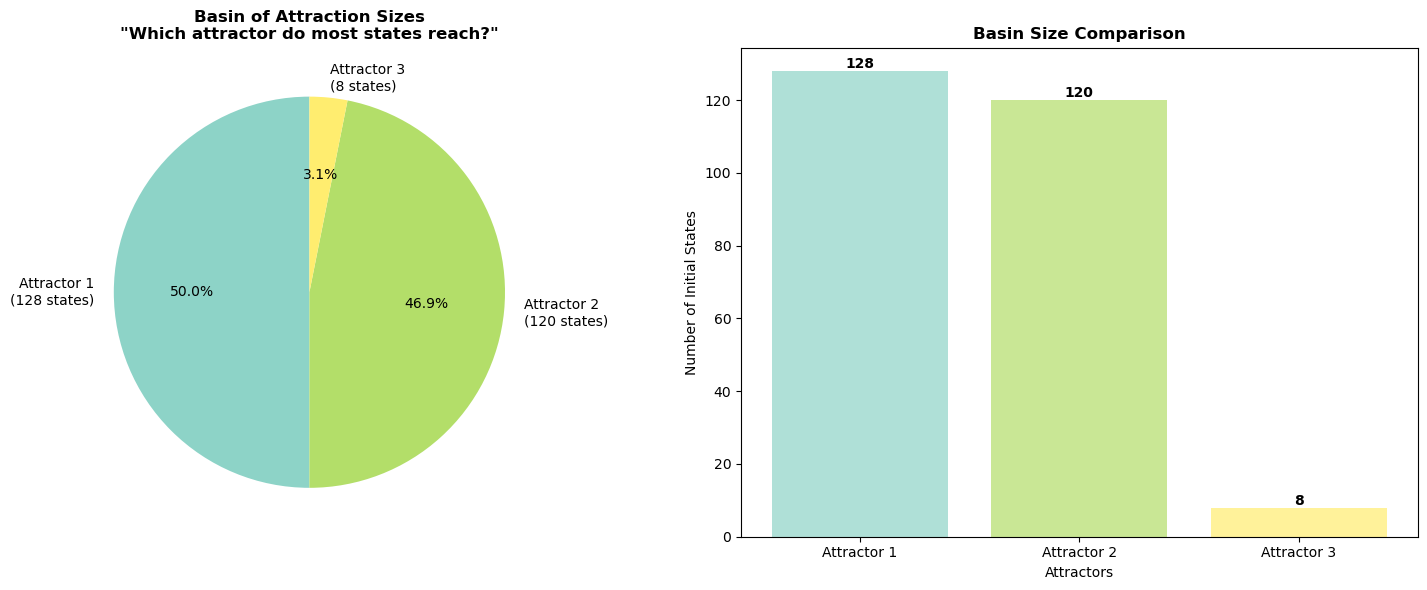

In [8]:
# 🟡 Which states end up in which attractor?

# Track which initial states lead to which attractors
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    # Set network state
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
    network.set_state(**state_dict)

    # Simulate
    trajectory = network.simulate(steps=max_steps, record_history=True)

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break

# Display basin sizes
print(f"\n Basin Sizes:")
total_states = len(all_states)
for att_idx in range(len(attractors)):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

# Create pie chart of basin sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))

wedges, texts, autotexts = ax1.pie(basin_sizes,
                                   labels=basin_labels,
                                   colors=colors,
                                   autopct='%1.1f%%',
                                   startangle=90)

ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"',
              fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)

ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size in zip(bars, basin_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()



---



# Common Code

In [9]:
scenarios = {
    'Healthy Cell': {'DNA_damage': 0, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Stressed Cell': { 'DNA_damage': 1, 'p53': 0, 'MYC': 0, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0},
    'Oncogene Hijacked Cell': { 'DNA_damage': 0, 'p53': 0, 'MYC': 1, 'CDK2': 0, 'MDM2': 0, 'p21': 0, 'Growth': 0, 'Death': 0}
}

# Part 2: Mutation A

p53 Knockout

In [10]:
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)




# Define Boolean rules - with p53 loss-of-function mutation
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")

network.add_rule('p53', lambda s: False, "p53 = BROKEN (always OFF)") # Simulate p53 loss-of-function

network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")





print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")
    
# Run healthy cell scenario
s = "Healthy Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run stressed cell scenario
s = "Stressed Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run oncogene hijacked cell scenario
s = "Oncogene Hijacked Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = BROKEN (always OFF)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Stressed Cell: Final state: Growth=1, Death=0, p53=0
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


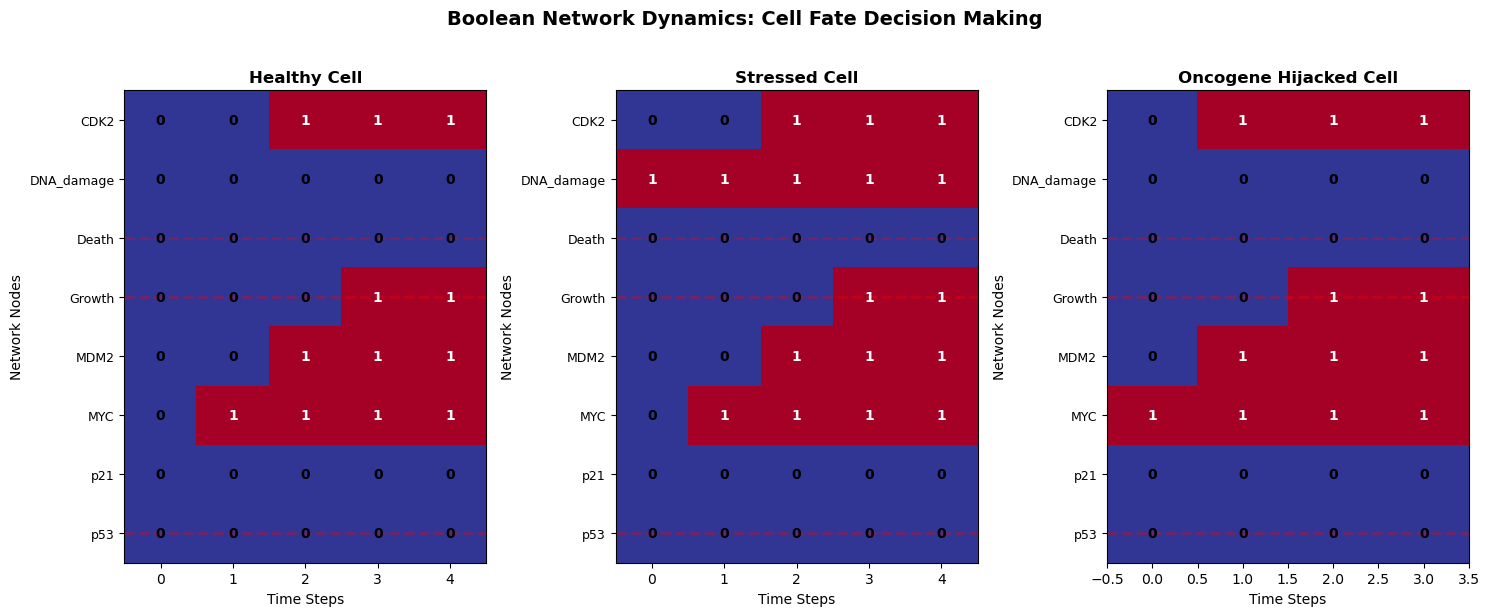

In [11]:
# Plot Evolution of initial state scenarios for this new network
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))
if n_scenarios ==1: axes = [axes]
for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]

    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation
    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')

    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:  # Changed variable name to avoid conflict
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **Atractor Analysis**

Testing all 256 possible initial states...

FOUND 2 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy Proliferation

Attractor 2: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth despite DNA Damage (Oncogenic)


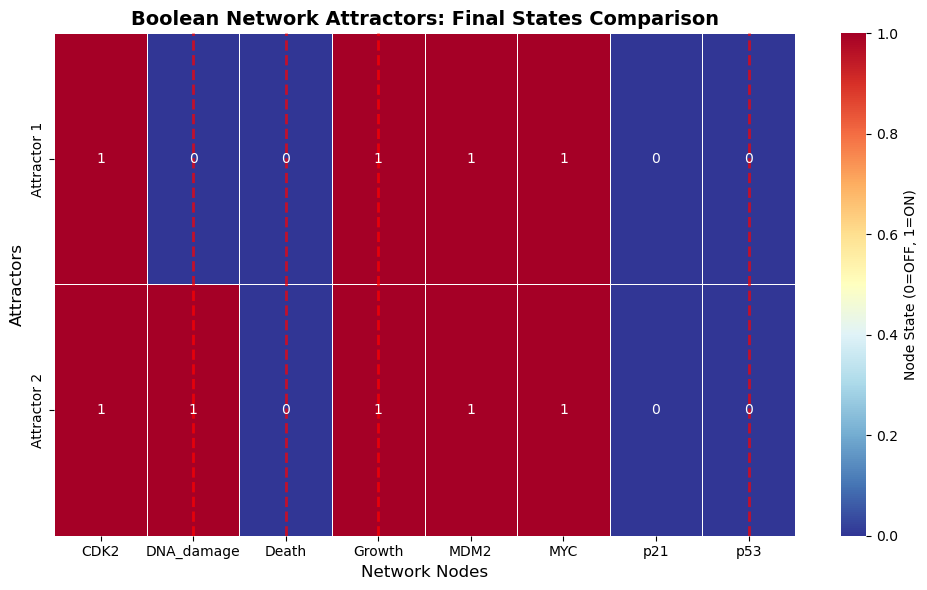

In [12]:
# Let's find the attractor states
attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)
print(f"Testing all {2**n_nodes} possible initial states...")
# Generate all possible initial states
all_states = list(product([0, 1], repeat=n_nodes))
for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)
  trajectory = network.simulate(steps=max_steps)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

# Let's find the attractor states
print(f"\nFOUND {len(attractors)} ATTRACTORS:")
for i, attractor in enumerate(attractors):
  print(f"\nAttractor {i+1}: {list(attractor)}")

  # Create state dictionary for easy access
  state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

  # Analyze the biological meaning
  growth_active = state_dict['Growth'] == 1
  death_active = state_dict['Death'] == 1
  p53_active = state_dict['p53'] == 1
  dna_damage_active = state_dict['DNA_damage'] == 1
  
  print(f"   Growth: {'ON' if growth_active else 'OFF'}")
  print(f"   Death: {'ON' if death_active else 'OFF'}")
  print(f"   p53: {'ON' if p53_active else 'OFF'}")
  print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

  if growth_active and not death_active and not dna_damage_active: interpretation = "Healthy Proliferation"
  elif death_active and not growth_active: interpretation = "DNA Damage-Induced Apoptosis"
  elif growth_active and not death_active and dna_damage_active: interpretation = "Growth despite DNA Damage (Oncogenic)"
  else: interpretation = "CONFLICT - Unusual state"

  print(f"   → {interpretation}")

# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

Analyzing 256 initial states...

 Basin Sizes:
   Attractor 1: 128 states ( 50.0%)
   Attractor 2: 128 states ( 50.0%)


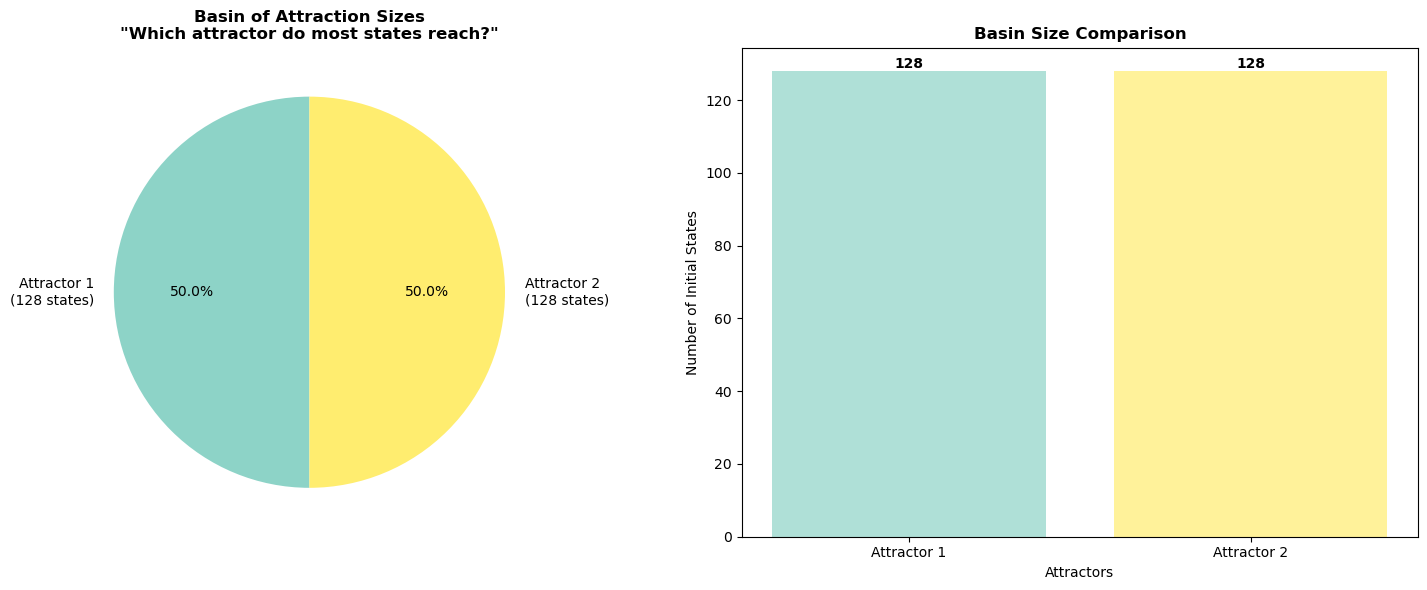

In [13]:
# Visualize basins of attraction
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}   # Set network state
    network.set_state(**state_dict)

    trajectory = network.simulate(steps=max_steps, record_history=True) # Simulate

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break

# Display basin sizes
print(f"\n Basin Sizes:")
total_states = len(all_states)
for att_idx in range(len(attractors)):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

# Create pie chart of basin sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))
wedges, texts, autotexts = ax1.pie(basin_sizes, labels=basin_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"', fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)
ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size in zip(bars, basin_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()



---



# Part 3: Mutation B

In [14]:
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)



# Define Boolean rules - with MYC amplification (oncogene always ON)
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")

network.add_rule('MYC', lambda s: True, "MYC = AMPLIFIED (always ON)") # Simulate MYC amplification

network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")





print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")
    
# Run healthy cell scenario
s = "Healthy Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run stressed cell scenario
s = "Stressed Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run oncogene hijacked cell scenario
s = "Oncogene Hijacked Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = AMPLIFIED (always ON)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Stressed Cell: Final state: Growth=1, Death=0, p53=0
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


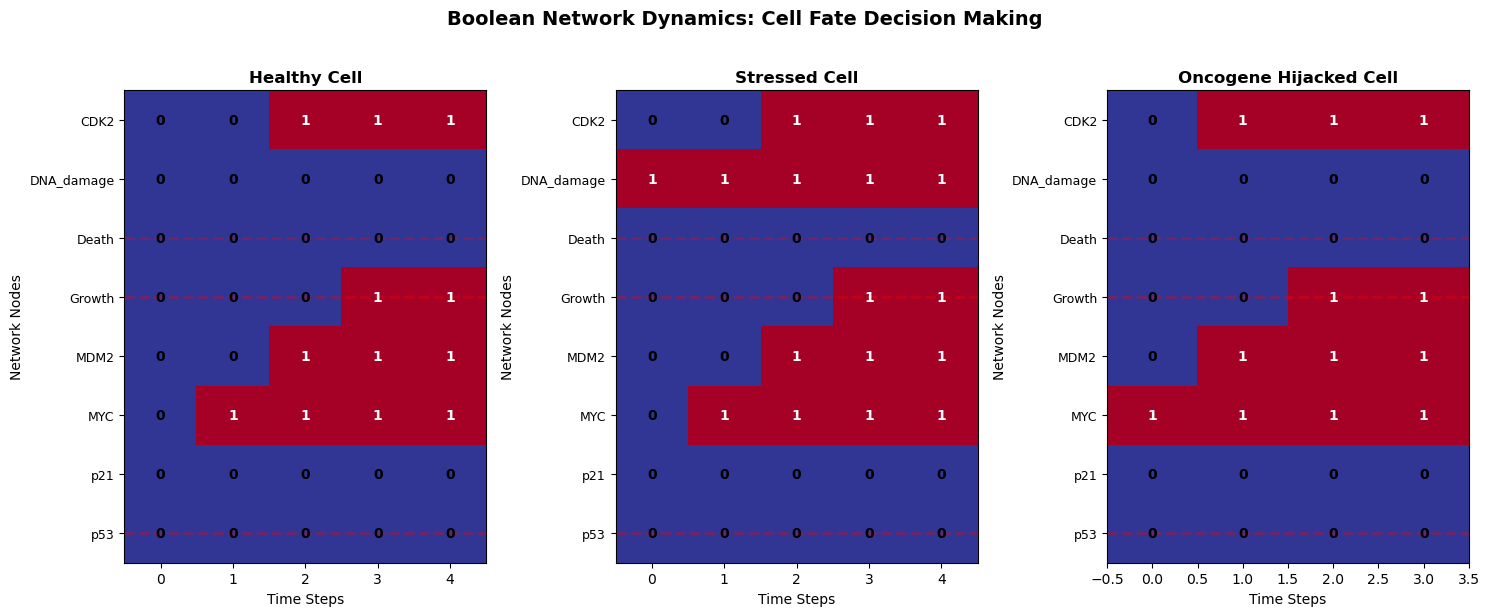

In [15]:
# Plot Evolution of initial state scenarios for this new network
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))
if n_scenarios ==1: axes = [axes]
for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]

    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation
    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')

    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:  # Changed variable name to avoid conflict
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **Atractor Analysis**

Testing all 256 possible initial states...

FOUND 4 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy Proliferation

Attractor 2: [0, 0, 0, 0, 1, 1, 1, 1]
   Growth: OFF
   Death: OFF
   p53: ON
   DNA Damage: OFF
   → CONFLICT - Unusual state

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth despite DNA Damage (Oncogenic)

Attractor 4: [0, 1, 1, 0, 1, 1, 1, 1]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → DNA Damage-Induced Apoptosis


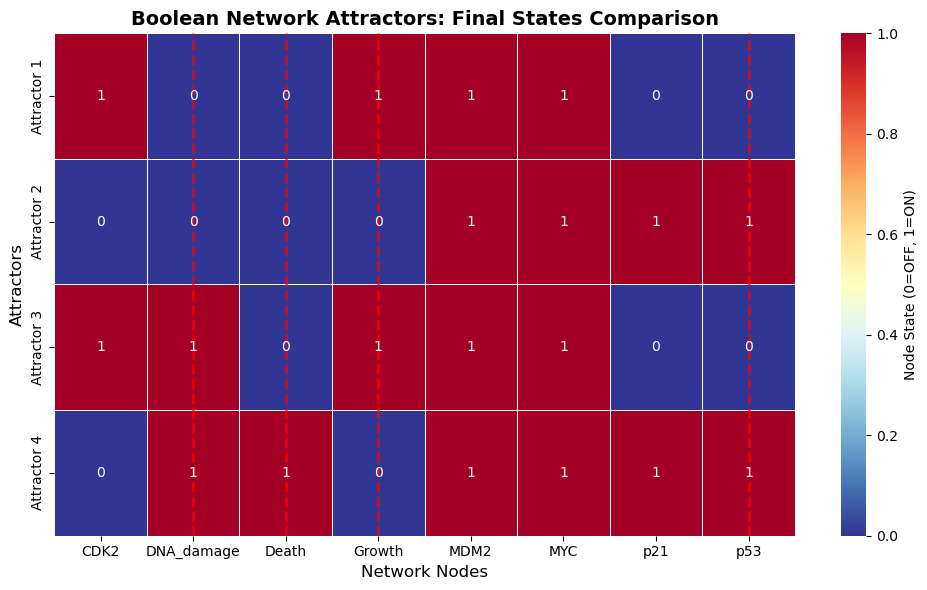

In [16]:
# Let's find the attractor states
attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)
print(f"Testing all {2**n_nodes} possible initial states...")
# Generate all possible initial states
all_states = list(product([0, 1], repeat=n_nodes))
for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)
  trajectory = network.simulate(steps=max_steps)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

# Let's find the attractor states
print(f"\nFOUND {len(attractors)} ATTRACTORS:")
for i, attractor in enumerate(attractors):
  print(f"\nAttractor {i+1}: {list(attractor)}")

  # Create state dictionary for easy access
  state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

  # Analyze the biological meaning
  growth_active = state_dict['Growth'] == 1
  death_active = state_dict['Death'] == 1
  p53_active = state_dict['p53'] == 1
  dna_damage_active = state_dict['DNA_damage'] == 1
  
  print(f"   Growth: {'ON' if growth_active else 'OFF'}")
  print(f"   Death: {'ON' if death_active else 'OFF'}")
  print(f"   p53: {'ON' if p53_active else 'OFF'}")
  print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

  if growth_active and not death_active and not dna_damage_active: interpretation = "Healthy Proliferation"
  elif death_active and not growth_active: interpretation = "DNA Damage-Induced Apoptosis"
  elif growth_active and not death_active and dna_damage_active: interpretation = "Growth despite DNA Damage (Oncogenic)"
  else: interpretation = "CONFLICT - Unusual state"

  print(f"   → {interpretation}")

# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

Analyzing 256 initial states...

 Basin Sizes:
   Attractor 1:  64 states ( 25.0%)
   Attractor 2:  64 states ( 25.0%)
   Attractor 3:  64 states ( 25.0%)
   Attractor 4:  64 states ( 25.0%)


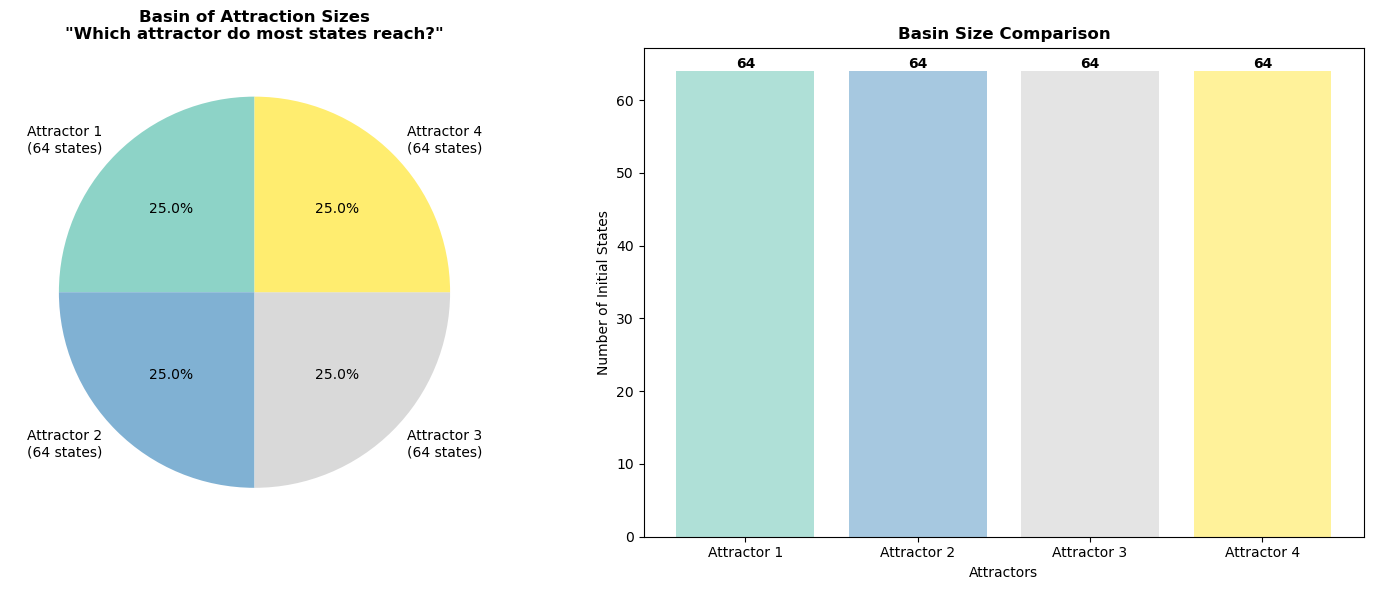

In [17]:
# Visualize basins of attraction
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}   # Set network state
    network.set_state(**state_dict)

    trajectory = network.simulate(steps=max_steps, record_history=True) # Simulate

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break

# Display basin sizes
print(f"\n Basin Sizes:")
total_states = len(all_states)
for att_idx in range(len(attractors)):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

# Create pie chart of basin sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))
wedges, texts, autotexts = ax1.pie(basin_sizes, labels=basin_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"', fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)
ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size in zip(bars, basin_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()



---



# Part 4: Mutation C

In [18]:
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)



# Define Boolean rules - with MDM2 overexpression (always ON)
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")

network.add_rule('MDM2', lambda s: True, "MDM2 = OVEREXPRESSED (always ON)") # Simulate MDM2 overexpression

network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")





print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")
    
# Run healthy cell scenario
s = "Healthy Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run stressed cell scenario
s = "Stressed Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run oncogene hijacked cell scenario
s = "Oncogene Hijacked Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = p53
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = OVEREXPRESSED (always ON)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Stressed Cell: Final state: Growth=1, Death=0, p53=0
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


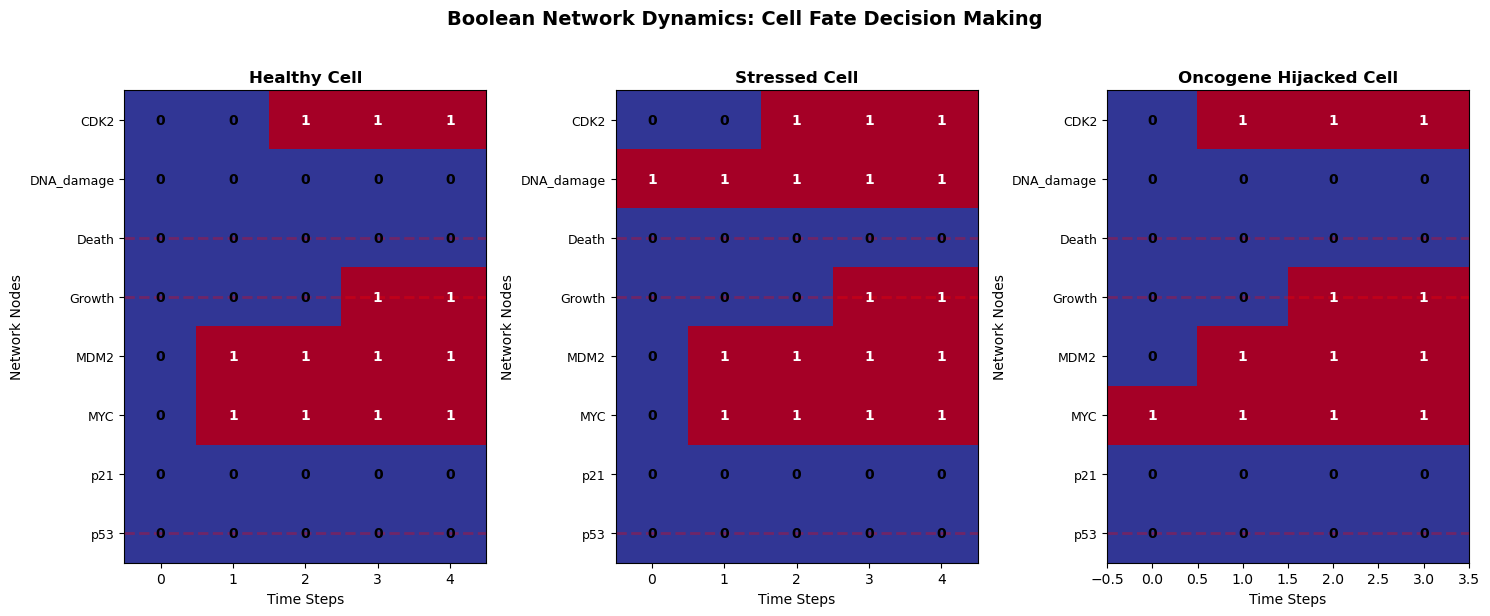

In [19]:
# Plot Evolution of initial state scenarios for this new network
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))
if n_scenarios ==1: axes = [axes]
for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]

    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation
    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')

    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:  # Changed variable name to avoid conflict
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **Atractor Analysis**

Testing all 256 possible initial states...

FOUND 4 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy Proliferation

Attractor 2: [0, 0, 0, 0, 1, 0, 1, 1]
   Growth: OFF
   Death: OFF
   p53: ON
   DNA Damage: OFF
   → CONFLICT - Unusual state

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth despite DNA Damage (Oncogenic)

Attractor 4: [0, 1, 1, 0, 1, 0, 1, 1]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → DNA Damage-Induced Apoptosis


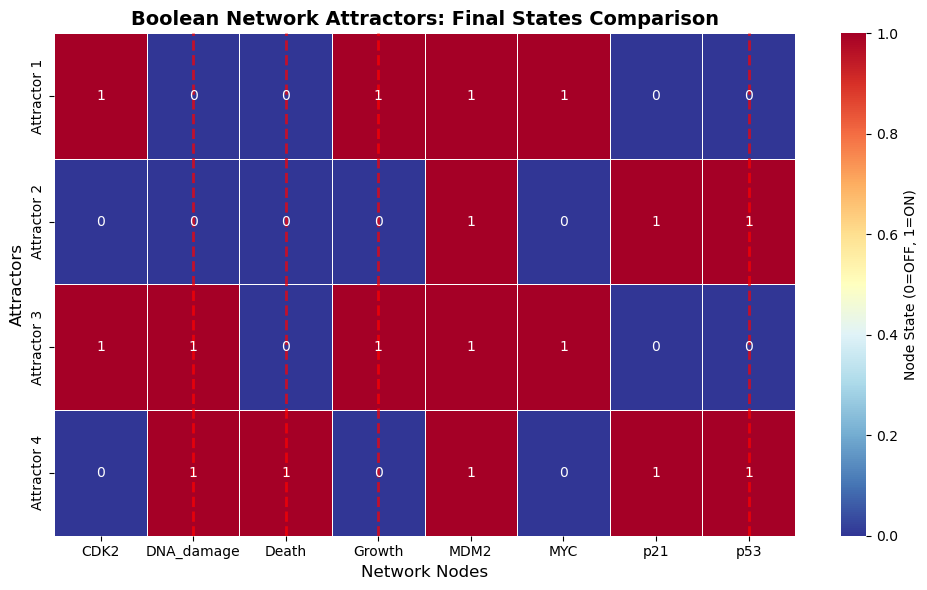

In [20]:
# Let's find the attractor states
attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)
print(f"Testing all {2**n_nodes} possible initial states...")
# Generate all possible initial states
all_states = list(product([0, 1], repeat=n_nodes))
for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)
  trajectory = network.simulate(steps=max_steps)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

# Let's find the attractor states
print(f"\nFOUND {len(attractors)} ATTRACTORS:")
for i, attractor in enumerate(attractors):
  print(f"\nAttractor {i+1}: {list(attractor)}")

  # Create state dictionary for easy access
  state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

  # Analyze the biological meaning
  growth_active = state_dict['Growth'] == 1
  death_active = state_dict['Death'] == 1
  p53_active = state_dict['p53'] == 1
  dna_damage_active = state_dict['DNA_damage'] == 1
  
  print(f"   Growth: {'ON' if growth_active else 'OFF'}")
  print(f"   Death: {'ON' if death_active else 'OFF'}")
  print(f"   p53: {'ON' if p53_active else 'OFF'}")
  print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

  if growth_active and not death_active and not dna_damage_active: interpretation = "Healthy Proliferation"
  elif death_active and not growth_active: interpretation = "DNA Damage-Induced Apoptosis"
  elif growth_active and not death_active and dna_damage_active: interpretation = "Growth despite DNA Damage (Oncogenic)"
  else: interpretation = "CONFLICT - Unusual state"

  print(f"   → {interpretation}")

# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

Analyzing 256 initial states...

 Basin Sizes:
   Attractor 1:  64 states ( 25.0%)
   Attractor 2:  64 states ( 25.0%)
   Attractor 3:  64 states ( 25.0%)
   Attractor 4:  64 states ( 25.0%)


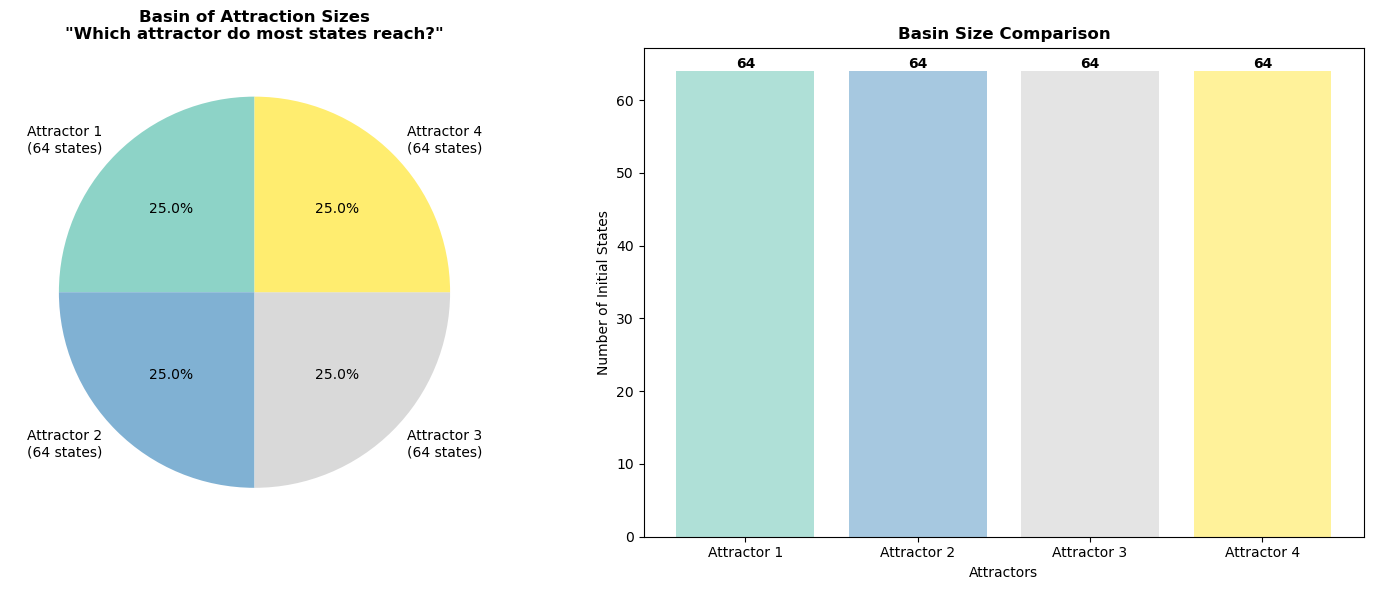

In [21]:
# Visualize basins of attraction
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}   # Set network state
    network.set_state(**state_dict)

    trajectory = network.simulate(steps=max_steps, record_history=True) # Simulate

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break

# Display basin sizes
print(f"\n Basin Sizes:")
total_states = len(all_states)
for att_idx in range(len(attractors)):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

# Create pie chart of basin sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))
wedges, texts, autotexts = ax1.pie(basin_sizes, labels=basin_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"', fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)
ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size in zip(bars, basin_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()



---



# Part 5: Mutation D

In [23]:
nodes = ['DNA_damage', 'p53', 'MYC', 'CDK2', 'MDM2', 'p21', 'Growth', 'Death']
network = BooleanNetwork(nodes)



# Define Boolean rules - with p21 knockout (always OFF)
network.add_rule('DNA_damage', lambda s: s['DNA_damage'], "DNA_damage = INPUT (constant)")
network.add_rule('p21', lambda s: s['p53'], "p21 = p53")
network.add_rule('MYC', lambda s: (not s['p53']) and (not s['p21']), "MYC = (NOT p53) AND (NOT p21)")
network.add_rule('CDK2', lambda s: s['MYC'] and (not s['p21']) and (not s['p53']), "CDK2 = MYC AND (NOT p21) AND (NOT p53)")
network.add_rule('MDM2', lambda s: s['MYC'], "MDM2 = MYC")
network.add_rule('p53', lambda s: s['DNA_damage'] and (not s['MDM2']), "p53 = DNA_damage AND (NOT MDM2)")


network.add_rule('p21', lambda s: False, "p21 = BROKEN (always OFF)") # Simulate p21 always off

network.add_rule('Growth',lambda s: s['CDK2'] and s['MYC'] and (not s['p53']), "Growth = CDK2 AND MYC AND (NOT p53)")
network.add_rule('Death', lambda s: s['p53'] and s['DNA_damage'] and (not s['Growth']), "Death = p53 AND DNA_damage AND (NOT Growth)")





print("Rules:")
for node, rule_info in network.rules.items():
    print(f" {rule_info['description']}")
    
# Run healthy cell scenario
s = "Healthy Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run stressed cell scenario
s = "Stressed Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

# Run oncogene hijacked cell scenario
s = "Oncogene Hijacked Cell"
initial_state = scenarios[s]
network.set_state(**initial_state)
trajectory = network.simulate(steps=8)
results[s] = trajectory
final_state = trajectory[-1]
node_names = sorted(network.nodes.keys())
final_dict = {node: final_state[i] for i, node in enumerate(node_names)}
print(f"   {s}: Final state: Growth={final_dict['Growth']}, Death={final_dict['Death']}, p53={final_dict['p53']}")

Rules:
 DNA_damage = INPUT (constant)
 p21 = BROKEN (always OFF)
 MYC = (NOT p53) AND (NOT p21)
 CDK2 = MYC AND (NOT p21) AND (NOT p53)
 MDM2 = MYC
 p53 = DNA_damage AND (NOT MDM2)
 Growth = CDK2 AND MYC AND (NOT p53)
 Death = p53 AND DNA_damage AND (NOT Growth)
   Healthy Cell: Final state: Growth=1, Death=0, p53=0
   Stressed Cell: Final state: Growth=0, Death=1, p53=1
   Oncogene Hijacked Cell: Final state: Growth=1, Death=0, p53=0


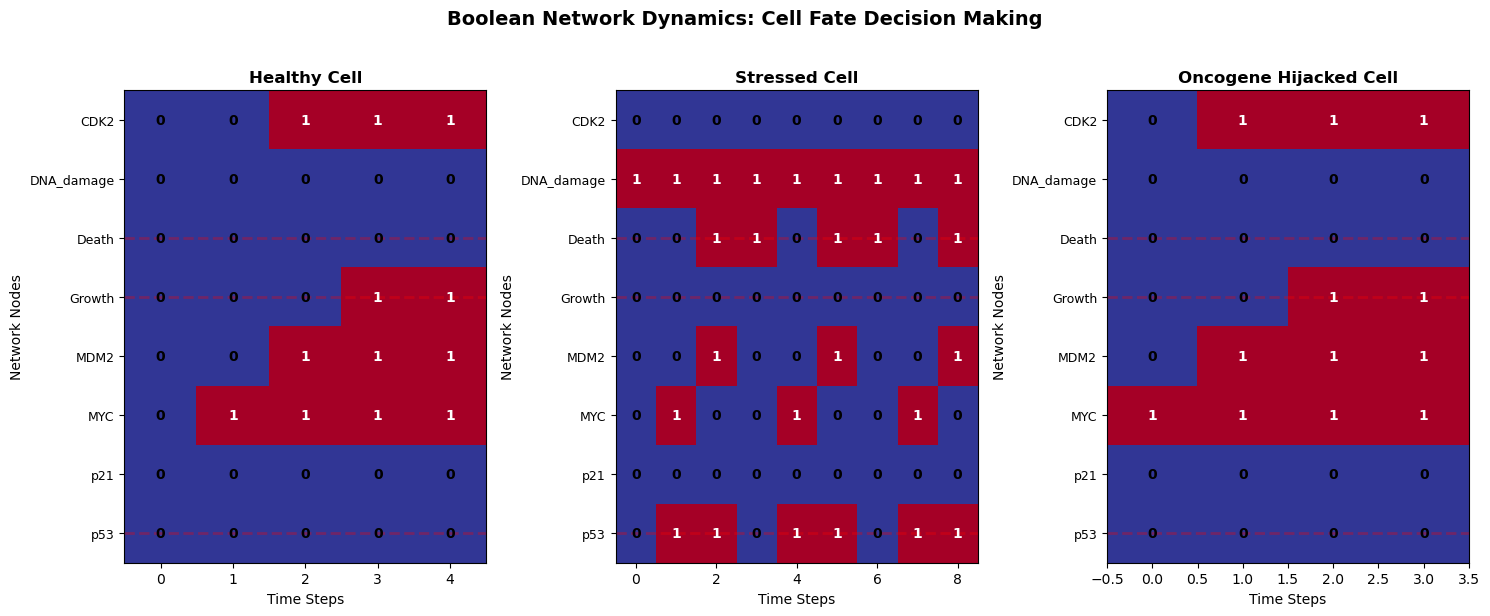

In [24]:
# Plot Evolution of initial state scenarios for this new network
n_scenarios = len(results)
fig, axes = plt.subplots(1, n_scenarios, figsize=(5*n_scenarios, 6))
if n_scenarios ==1: axes = [axes]
for scenario_idx, (scenario_name, trajectory) in enumerate(results.items()):
    ax = axes[scenario_idx]

    # Create heatmap
    trajectory_matrix = trajectory.T  # Transpose for proper orientation
    im = ax.imshow(trajectory_matrix, cmap='RdYlBu_r', aspect='auto', interpolation='nearest')

    # Formatting
    ax.set_title(f'{scenario_name}', fontweight='bold', fontsize=12)
    ax.set_xlabel('Time Steps', fontsize=10)
    ax.set_ylabel('Network Nodes', fontsize=10)
    ax.set_yticks(range(len(node_names)))
    ax.set_yticklabels(node_names, fontsize=9)

    # Add text annotations
    for t in range(trajectory.shape[0]):
        for n in range(len(node_names)):
            color = 'white' if trajectory_matrix[n, t] == 1 else 'black'
            ax.text(t, n, int(trajectory_matrix[n, t]),
                   ha="center", va="center", color=color, fontweight='bold')

    # Highlight key output nodes
    output_indices = [i for i, name in enumerate(node_names) if name in ['Growth', 'Death', 'p53']]
    for output_idx in output_indices:  # Changed variable name to avoid conflict
        ax.axhline(y=output_idx, color='red', linestyle='--', alpha=0.3, linewidth=2)

plt.suptitle('Boolean Network Dynamics: Cell Fate Decision Making',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

### **Atractor Analysis**

Testing all 256 possible initial states...

FOUND 3 ATTRACTORS:

Attractor 1: [1, 0, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: OFF
   → Healthy Proliferation

Attractor 2: [0, 1, 1, 0, 0, 0, 0, 1]
   Growth: OFF
   Death: ON
   p53: ON
   DNA Damage: ON
   → DNA Damage-Induced Apoptosis

Attractor 3: [1, 1, 0, 1, 1, 1, 0, 0]
   Growth: ON
   Death: OFF
   p53: OFF
   DNA Damage: ON
   → Growth despite DNA Damage (Oncogenic)


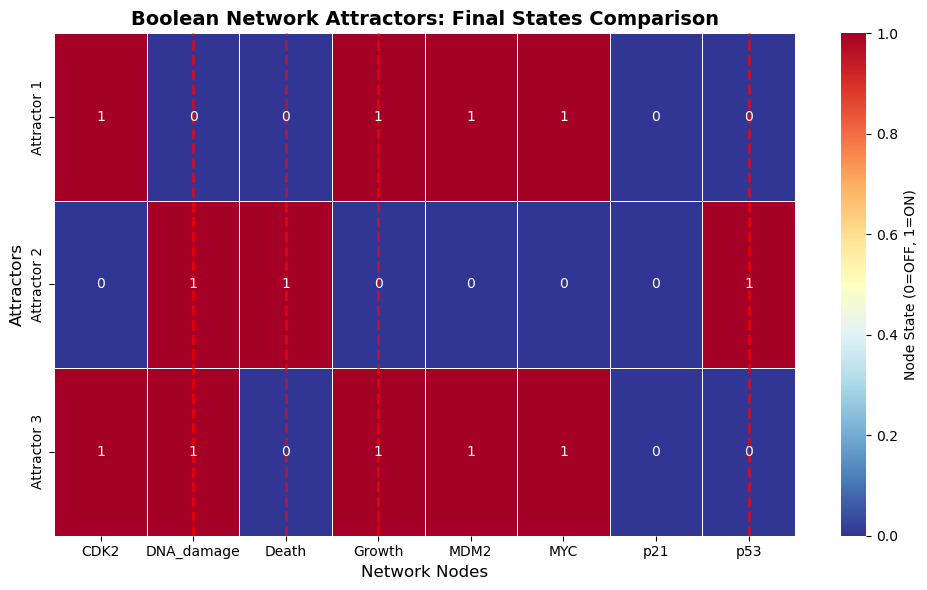

In [25]:
# Let's find the attractor states
attractors = []
max_steps=15
node_names = sorted(network.nodes.keys())
n_nodes = len(node_names)
print(f"Testing all {2**n_nodes} possible initial states...")
# Generate all possible initial states
all_states = list(product([0, 1], repeat=n_nodes))
for initial_state in all_states:
  # Set the network to this initial state
  state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}
  network.set_state(**state_dict)
  trajectory = network.simulate(steps=max_steps)

  # Check if it reached a steady state (last two states are the same)
  if len(trajectory) >= 2:
    final_state = tuple(trajectory[-1])  # Convert to tuple for comparison

  # Check if this is a new attractor
    if np.array_equal(trajectory[-1], trajectory[-2]):  # Steady state reached
      if final_state not in attractors:
        attractors.append(final_state)

# Let's find the attractor states
print(f"\nFOUND {len(attractors)} ATTRACTORS:")
for i, attractor in enumerate(attractors):
  print(f"\nAttractor {i+1}: {list(attractor)}")

  # Create state dictionary for easy access
  state_dict = {node_names[j]: attractor[j] for j in range(len(node_names))}

  # Analyze the biological meaning
  growth_active = state_dict['Growth'] == 1
  death_active = state_dict['Death'] == 1
  p53_active = state_dict['p53'] == 1
  dna_damage_active = state_dict['DNA_damage'] == 1
  
  print(f"   Growth: {'ON' if growth_active else 'OFF'}")
  print(f"   Death: {'ON' if death_active else 'OFF'}")
  print(f"   p53: {'ON' if p53_active else 'OFF'}")
  print(f"   DNA Damage: {'ON' if dna_damage_active else 'OFF'}")

  if growth_active and not death_active and not dna_damage_active: interpretation = "Healthy Proliferation"
  elif death_active and not growth_active: interpretation = "DNA Damage-Induced Apoptosis"
  elif growth_active and not death_active and dna_damage_active: interpretation = "Growth despite DNA Damage (Oncogenic)"
  else: interpretation = "CONFLICT - Unusual state"

  print(f"   → {interpretation}")

# Convert attractors to clean matrix
attractor_matrix = []
for attractor in attractors:
    clean_row = [int(x) for x in attractor]
    attractor_matrix.append(clean_row)

attractor_matrix = np.array(attractor_matrix)

# Create heatmap
plt.figure(figsize=(10, max(6, len(attractors))))

# Create heatmap with custom colors
ax = sns.heatmap(attractor_matrix,
                 xticklabels=node_names,
                 yticklabels=[f'Attractor {i+1}' for i in range(len(attractors))],
                 cmap='RdYlBu_r',
                 cbar_kws={'label': 'Node State (0=OFF, 1=ON)'},
                 annot=True,
                 fmt='d',
                 linewidths=0.5)

plt.title('Boolean Network Attractors: Final States Comparison',
          fontsize=14, fontweight='bold')
plt.xlabel('Network Nodes', fontsize=12)
plt.ylabel('Attractors', fontsize=12)

# Highlight key output nodes
output_nodes = ['Growth', 'Death', 'p53', 'DNA_damage']
for node in output_nodes:
    if node in node_names:
        idx = node_names.index(node)
        ax.axvline(x=idx+0.5, color='red', linestyle='--', alpha=0.7, linewidth=2)

plt.tight_layout()
plt.show()

Analyzing 256 initial states...

 Basin Sizes:
   Attractor 1: 128 states ( 50.0%)
   Attractor 2:  24 states (  9.4%)
   Attractor 3:   8 states (  3.1%)


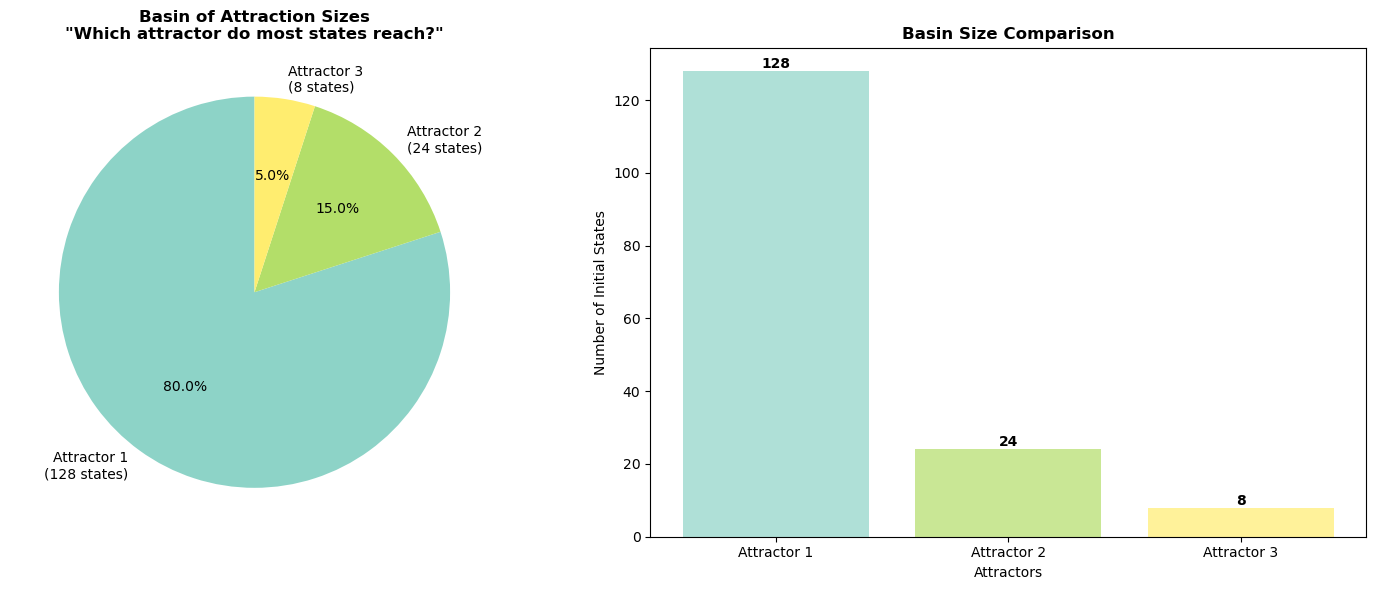

In [27]:
# Visualize basins of attraction
basin_data = defaultdict(list)  # attractor -> list of initial states
attractor_map = {}  # initial_state -> attractor_index

n_nodes = len(node_names)
all_states = list(product([0, 1], repeat=n_nodes))
print(f"Analyzing {len(all_states)} initial states...")

for initial_state in all_states:
    state_dict = {node_names[i]: initial_state[i] for i in range(n_nodes)}   # Set network state
    network.set_state(**state_dict)

    trajectory = network.simulate(steps=max_steps, record_history=True) # Simulate

    # Find which attractor this leads to
    if len(trajectory) >= 2 and np.array_equal(trajectory[-1], trajectory[-2]):
        final_state = tuple(int(x) for x in trajectory[-1])  # Clean conversion

        # Find matching attractor
        for att_idx, attractor in enumerate(attractors):
            clean_attractor = tuple(int(x) for x in attractor)
            if final_state == clean_attractor:
                basin_data[att_idx].append(initial_state)
                attractor_map[initial_state] = att_idx
                break

# Display basin sizes
print(f"\n Basin Sizes:")
total_states = len(all_states)
for att_idx in range(len(attractors)):
    basin_size = len(basin_data[att_idx])
    percentage = (basin_size / total_states) * 100
    print(f"   Attractor {att_idx+1}: {basin_size:3d} states ({percentage:5.1f}%)")

# Create pie chart of basin sizes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# Pie chart of basin sizes
basin_sizes = [len(basin_data[i]) for i in range(len(attractors))]
basin_labels = [f'Attractor {i+1}\n({size} states)' for i, size in enumerate(basin_sizes)]
colors = plt.cm.Set3(np.linspace(0, 1, len(attractors)))
wedges, texts, autotexts = ax1.pie(basin_sizes, labels=basin_labels, colors=colors, autopct='%1.1f%%', startangle=90)
ax1.set_title('Basin of Attraction Sizes\n"Which attractor do most states reach?"', fontsize=12, fontweight='bold')

# Bar chart comparison
attractor_names = [f'Attractor {i+1}' for i in range(len(attractors))]
bars = ax2.bar(attractor_names, basin_sizes, color=colors, alpha=0.7)
ax2.set_title('Basin Size Comparison', fontsize=12, fontweight='bold')
ax2.set_ylabel('Number of Initial States', fontsize=10)
ax2.set_xlabel('Attractors', fontsize=10)

# Add value labels on bars
for bar, size in zip(bars, basin_sizes):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height, f'{size}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()